In [4]:
%load_ext autoreload
%autoreload 2

In [2]:
from x2 import X2Env
env = X2Env()

# import gymnasium as gym
# env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

In [3]:
from code.rng import set_seeds, SEED
set_seeds()

In [4]:
from code.agent import DQNAgent

# parameters
num_frames = 30000
memory_size = 10000
batch_size = 128
target_update = 100

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, SEED)

26 5
cuda


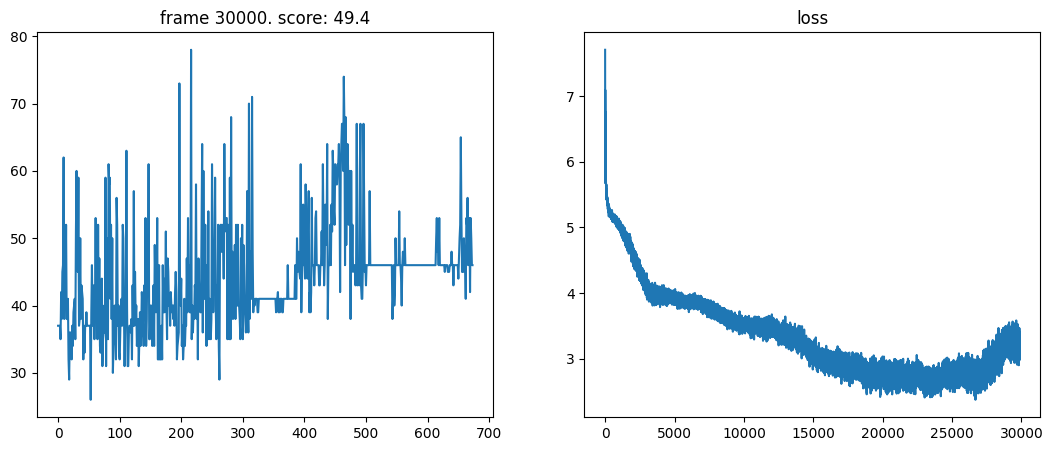

In [5]:
agent.train(num_frames)

In [8]:
from typing import List
import numpy as np

env = X2Env()
state, _ = env.reset()

rewards: List[int] = []

for s in range(1000):
    env.reset(seed=s)
    r = 0

    while True:
        action = agent.select_action(state)
        state, reward, done, _, _ = env.step(action)

        r += reward

        if done:
            rewards.append(r)
            break
            
env.close()

np.mean(rewards), np.std(rewards)

(10.753, 7.042300121409198)

In [35]:
from x2 import X2Env
from stable_baselines3 import PPO
from uuid import uuid4

env = X2Env()

model = PPO("MlpPolicy", env, verbose=1, seed=0)
model.learn(total_timesteps=100_000)

path = f'models/{uuid4()}.model'
print(path)

model.save(path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49.8     |
|    ep_rew_mean     | 27.7     |
| time/              |          |
|    fps             | 541      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.6        |
|    ep_rew_mean          | 31.8        |
| time/                   |             |
|    fps                  | 377         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010486189 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss  

In [36]:
from typing import List
import numpy as np

env = X2Env()
state, _ = env.reset()

rewards: List[int] = []

for s in range(1000):
    env.reset(seed=s)
    r = 0

    while True:
        action, _ = model.predict(state, deterministic=True)
        state, reward, done, _, _ = env.step(action)

        r += reward

        if done:
            rewards.append(r)
            break
            
env.close()

np.mean(rewards), np.std(rewards)

(54.577, 20.316005291395257)

array([[<AxesSubplot:title={'center':'reward'}>]], dtype=object)

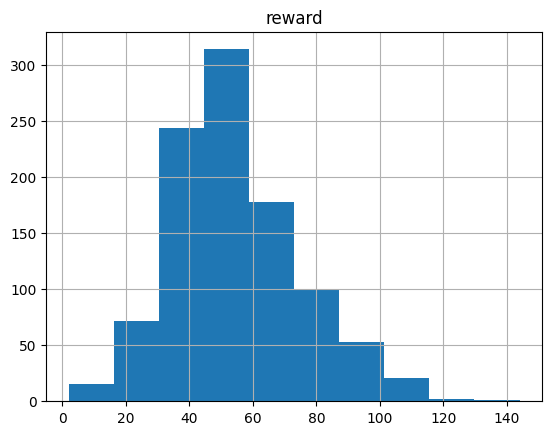

In [37]:
import pandas as pd

df = pd.DataFrame(rewards, columns=['reward'])
df.hist()

In [39]:
seed = int(np.argmax(rewards))
print(seed)

env = X2Env()
state, _ = env.reset(seed=seed)

789


In [43]:
from x2 import print_grid

print_grid(env._state.grid)

action, _ = model.predict(state, deterministic=True)

print()

next_state, reward, done, _, _ = env.step(action)

print_grid(env._state.grid)
print(f'next: {env._state.next_play} action: {action}')




0005 0006 ---- ---- ----
0006 ---- ---- ---- ----
---- ---- ---- ---- ----
---- ---- ---- ---- ----
---- ---- ---- ---- ----

0005 0006 ---- 0001 ----
0006 ---- ---- ---- ----
---- ---- ---- ---- ----
---- ---- ---- ---- ----
---- ---- ---- ---- ----
next: 3 action: 3
